## This is the svm workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a linear support vector machine.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and includes code to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training an SVM classifier via gradient descent.

## Importing libraries and data setup

In [2]:
import numpy as np # for doing most of our calculations
import matplotlib.pyplot as plt# for plotting
from cs231n.data_utils import load_CIFAR10 # function to load the CIFAR-10 dataset.
import pdb

# Load matplotlib images inline
%matplotlib inline

# These are important for reloading any code you write in external .py files.
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
# Set the path to the CIFAR-10 data
cifar10_dir = '/home/alon/school/c247a/datasets/cifar-10-batches-py' # You need to update this line
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


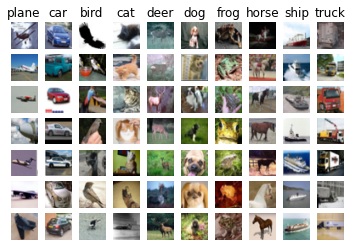

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Dev data shape: ', X_dev.shape)
print('Dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
Dev data shape:  (500, 32, 32, 3)
Dev labels shape:  (500,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


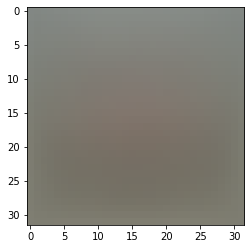

In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [8]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [9]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## Question:

(1) For the SVM, we perform mean-subtraction on the data.
However, for the KNN notebook, we did not.
Why?

## Answer:

(1) For the SVM, we do this to center each image relative to the rest of the dataset. This probably helps to keep gradients reasonable. Each input gets the same weights applied to it, so we want them to be trained on a "centered" dataset. For the KNN classifier, we don't need to do this, because we actually use the distance between input examples in order to calculate the output, and shifting everything by the same amount wouldn't change the relative distances or the outcome.

## Training an SVM

The following cells will take you through building an SVM.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [10]:
from nndl.svm import SVM

In [11]:
# Declare an instance of the SVM class.  
# Weights are initialized to a random value.
# Note, to keep people's initial solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

svm = SVM(dims=[num_classes, num_features])

#### SVM loss

In [12]:
## Implement the loss function for in the SVM class(nndl/svm.py), svm.loss()

loss = svm.loss(X_train, y_train)
print('The training set loss is {}.'.format(loss))

# If you implemented the loss correctly, it should be 15569.98

The training set loss is 15569.977915410242.


In [13]:
loss = svm.loss(X_dev, y_dev)
print('The dev set loss is {}.'.format(loss))

The dev set loss is 15584.739555166354.


#### SVM gradient

In [14]:
#print(X_train.shape)

In [15]:
## Calculate the gradient of the SVM class.
# For convenience, we'll write one function that computes the loss
#   and gradient together. Please modify svm.loss_and_grad(X, y).
# You may copy and paste your loss code from svm.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = svm.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a numerical gradient check. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
svm.grad_check_sparse(X_dev, y_dev, grad)

numerical: -8.522250 analytic: -8.522249, relative error: 2.391779e-08
numerical: 6.125786 analytic: 6.125786, relative error: 1.320482e-08
numerical: -6.109695 analytic: -6.109695, relative error: 3.120147e-09
numerical: 5.110966 analytic: 5.110965, relative error: 7.267097e-08
numerical: 6.859735 analytic: 6.859735, relative error: 1.082414e-08
numerical: 4.314657 analytic: 4.314657, relative error: 2.091458e-08
numerical: 9.326083 analytic: 9.326082, relative error: 1.878566e-08
numerical: -15.829804 analytic: -15.829804, relative error: 1.659177e-08
numerical: 2.708752 analytic: 2.708752, relative error: 4.687877e-08
numerical: -15.970575 analytic: -15.970574, relative error: 6.427133e-09


## A vectorized version of SVM

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [16]:
import time

In [17]:
#try to remove the j loop first

loss = 0.0

for i in range(0, X_train.shape[0]):
    scores = np.dot(X_train[i], svm.W.T) #(num_classes x 1 vector)
    correct_class_score = scores[y_train[i]] #scalar
    
    #print(y_dev[i])
    temp = (scores - correct_class_score)
    #print(temp.shape)
    z_js = np.ones_like(scores) + temp
    z_js[z_js < 0] = 0
    
    #now just need to sum up all the incorrect class terms in each row
    row_sum = np.sum(z_js[np.arange(len(z_js)) != y_train[i]])
    loss += row_sum
    
loss /= X_train.shape[0]

print(loss)

15569.977915410242


In [18]:
#now remove i loop

scores = np.dot(X_train, svm.W.T) #(num_samples x num_classes vector)
correct_class_score = np.choose(y_train, scores.T)
#print(correct_class_score.shape)

#now we want z_js to be num_samples x num_classes

#temp = (scores - correct_class_score.reshape(X_train.shape[0],1))
z_js = np.maximum(0, 1 + (scores - correct_class_score.reshape(X_train.shape[0],1)))
#z_js[z_js < 0] = 0
#print(z_js.shape)

z_js[np.arange(X_train.shape[0]), y_train] = 0
row_sums = np.sum(z_js, axis=1)
#row_sums = np.sum(z_js, axis=1) - np.choose(y_train, z_js.T)
# print(row_sums.shape)
# print(z_js[y_train].shape)

loss = np.sum(row_sums)/X_train.shape[0]
print(loss)

15569.97791541023


In [21]:
## Implement svm.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = svm.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = svm.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} / {}'.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output, i.e., differences on the order of 1e-12

Normal loss / grad_norm: 15584.739555166354 / 2017.1983969632684 computed in 0.043683767318725586s
Vectorized loss / grad: 15584.73955516636 / 2017.1983969632681 computed in 0.0040471553802490234s
difference in loss / grad: -5.4569682106375694e-12 / 3.618512721556333e-12


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 16878.859625643898
iteration 100 / 1500: loss 3698.374429445832
iteration 200 / 1500: loss 3749.3722795434505
iteration 300 / 1500: loss 3232.2016048804485
iteration 400 / 1500: loss 2786.9285054561765
iteration 500 / 1500: loss 2911.8902158068004
iteration 600 / 1500: loss 2696.12348093388
iteration 700 / 1500: loss 2959.5756376002887
iteration 800 / 1500: loss 2512.8602634753483
iteration 900 / 1500: loss 2105.966992162575
iteration 1000 / 1500: loss 2313.4288377704447
iteration 1100 / 1500: loss 1732.4754464411596
iteration 1200 / 1500: loss 2114.4851353256367
iteration 1300 / 1500: loss 2050.9948002316255
iteration 1400 / 1500: loss 1814.3598110234702
That took 7.542051076889038s


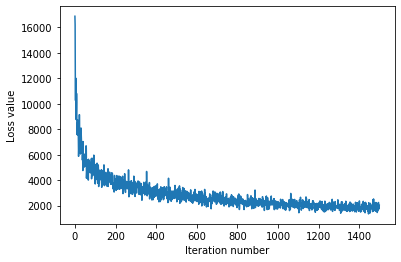

In [22]:
# Implement svm.train() by filling in the code to extract a batch of data
# and perform the gradient step.

tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=5e-4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained SVM on the validation data.

In [23]:
## Implement svm.predict() and use it to compute the training and testing error.

y_train_pred = svm.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = svm.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.29612244897959183
validation accuracy: 0.303


## Optimize the SVM

Note, to make things faster and simpler, we won't do k-fold cross-validation, but will only optimize the hyperparameters on the validation dataset (X_val, y_val).

In [24]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the SVM with different learning rates and evaluate on the
#     validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best VALIDATION accuracy corresponding to the best VALIDATION error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
#   Note: You do not need to modify SVM class for this section
# ================================================================ #

#try learning rates between 10^-6 and 10^-3 in increments of 2.5e-6
learning_rates = np.linspace(1e-6, 1e-1, 100)

best_learning_rate = 0.0
best_val_accuracy = 0.0

for learning_rate in learning_rates:
    svm.train(X_train, y_train, learning_rate=learning_rate,
                      num_iters=1500, verbose=False)
    y_pred_validation = svm.predict(X_val)
    val_accuracy = np.mean(np.equal(y_val,y_pred_validation))
    print("Validation accuracy for {}: {}".format(learning_rate, val_accuracy))
    
    if (val_accuracy > best_val_accuracy):
        #update
        best_val_accuracy = val_accuracy
        best_learning_rate = learning_rate
        
print('\n')
    
print("best learning rate is: {}".format(best_learning_rate))
    
#retrain and test on best learning rate
svm.train(X_train, y_train, learning_rate=best_learning_rate, num_iters=1500, verbose=True)
y_test_pred = svm.predict(X_test)
test_accuracy = np.mean(np.equal(y_test,y_test_pred))

print("Test accuracy at best rate is: {}".format(test_accuracy))


# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

Validation accuracy for 1e-06: 0.142
Validation accuracy for 0.001011090909090909: 0.29
Validation accuracy for 0.0020211818181818182: 0.308
Validation accuracy for 0.003031272727272727: 0.282
Validation accuracy for 0.004041363636363636: 0.294
Validation accuracy for 0.005051454545454546: 0.334
Validation accuracy for 0.006061545454545454: 0.317
Validation accuracy for 0.007071636363636363: 0.307
Validation accuracy for 0.008081727272727272: 0.362
Validation accuracy for 0.00909181818181818: 0.262
Validation accuracy for 0.01010190909090909: 0.313
Validation accuracy for 0.011111999999999999: 0.275
Validation accuracy for 0.012122090909090907: 0.289
Validation accuracy for 0.013132181818181817: 0.329
Validation accuracy for 0.014142272727272726: 0.317
Validation accuracy for 0.015152363636363636: 0.288
Validation accuracy for 0.016162454545454546: 0.286
Validation accuracy for 0.017172545454545454: 0.285
Validation accuracy for 0.018182636363636363: 0.325
Validation accuracy for 0.019

In [184]:
test_accuracy = np.mean(np.equal(y_test,y_test_pred))
print(test_accuracy)

0.27


In [ ]:
import numpy as np
import pdb

"""
This code was based off of code from cs231n at Stanford University, and modified for ECE C147/C247 at UCLA.
"""
class SVM(object):

  def __init__(self, dims=[10, 3073]):
    self.init_weights(dims=dims)

  def init_weights(self, dims):
    """
	Initializes the weight matrix of the SVM.  Note that it has shape (C, D)
	where C is the number of classes and D is the feature size.
	"""
    self.W = np.random.normal(size=dims)

  def loss(self, X, y):
    """
    Calculates the SVM loss.

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.

    Returns a tuple of:
    - loss as single float
    """

    # compute the loss and the gradient
    num_classes = self.W.shape[0]
    num_train = X.shape[0]
    loss = 0.0

    for i in np.arange(num_train):
    # ================================================================ #
    # YOUR CODE HERE:
	  #   Calculate the normalized SVM loss, and store it as 'loss'.
    #   (That is, calculate the sum of the losses of all the training
    #   set margins, and then normalize the loss by the number of
	  #	  training examples.)
    # ================================================================ #
        #loss is 1/num_train * sum over all examples(sum over all classes not equal to the correct class(max(0, 1 + score_class(xi) - score_correct_class(xi))))
        scores = np.dot(X[i], self.W.T)
        correct_class_score = scores[y[i]]
        hinge_terms = []
        for j in range(0, num_classes):
            if j == y[i]:
                continue
            else:
                class_score = scores[j]
                term = max(0, 1 + class_score - correct_class_score)
                hinge_terms.append(term)

        hinge_sum = np.sum(hinge_terms)
        loss += hinge_sum

    loss = loss/num_train

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss

  def loss_and_grad(self, X, y):
    """
	Same as self.loss(X, y), except that it also returns the gradient.

	Output: grad -- a matrix of the same dimensions as W containing
		the gradient of the loss with respect to W.
	"""

    # compute the loss and the gradient
    num_classes = self.W.shape[0]
    num_train = X.shape[0]
    loss = 0.0
    grad = np.zeros_like(self.W)

    for i in np.arange(num_train):
    # ================================================================ #
    # YOUR CODE HERE:
	#   Calculate the SVM loss and the gradient.  Store the gradient in
    #   the variable grad.
    # ================================================================ #
        scores = np.dot(X[i], self.W.T)
        correct_class_score = scores[y[i]]
        hinge_terms = []

        for j in range(0, num_classes):
            if j == y[i]:
                continue
            else:
                class_score = scores[j]
                z_j = 1 + class_score - correct_class_score
                term = max(0, z_j)
                hinge_terms.append(term)

                #now do gradient stuff:
                if z_j <= 0:
                    continue
                else:
                    grad[j] += X[i]
                    grad[y[i]] -= X[i]

        hinge_sum = np.sum(hinge_terms)
        loss += hinge_sum

    #loss = loss/num_train


    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    loss /= num_train
    grad /= num_train

    return loss, grad

  def grad_check_sparse(self, X, y, your_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in these dimensions.
    """

    for i in np.arange(num_checks):
      ix = tuple([np.random.randint(m) for m in self.W.shape])

      oldval = self.W[ix]
      self.W[ix] = oldval + h # increment by h
      fxph = self.loss(X, y)
      self.W[ix] = oldval - h # decrement by h
      fxmh = self.loss(X,y) # evaluate f(x - h)
      self.W[ix] = oldval # reset

      grad_numerical = (fxph - fxmh) / (2 * h)
      grad_analytic = your_grad[ix]
      rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
      print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

  def fast_loss_and_grad(self, X, y):
    """
    A vectorized implementation of loss_and_grad. It shares the same
	inputs and ouptuts as loss_and_grad.
    """
    loss = 0.0
    grad = np.zeros(self.W.shape) # initialize the gradient as zero

    # ================================================================ #
    # YOUR CODE HERE:
	#   Calculate the SVM loss WITHOUT any for loops.
    # ================================================================ #
    scores = np.dot(X, self.W.T) #(num_samples x num_classes vector)
    correct_class_score = np.choose(y, scores.T)
    #print(correct_class_score.shape)

    #now we want z_js to be num_samples x num_classes

    #temp = (scores - correct_class_score.reshape(X_train.shape[0],1))
    z_js = np.maximum(0, 1 + (scores - correct_class_score.reshape(X.shape[0],1)))
    #z_js[z_js < 0] = 0
    #print(z_js.shape)

    z_js[np.arange(X.shape[0]), y] = 0
    row_sums = z_js.sum()
    #row_sums = np.sum(z_js, axis=1) - np.choose(y_train, z_js.T)
    # print(row_sums.shape)
    # print(z_js[y_train].shape)
            #now implement gradient
            #gradient is just -1*sum_over_incorrect_classes(indicator(Zj > 0)*Xi)
            #Zj = 1 + score_class - score_correct_class
    loss = row_sums/(X.shape[0])


    # scores = np.dot(X, self.W.T) #(num_samples x num_classes vector)
    # correct_class_score = np.choose(y, scores.T)
    # temp = (scores - correct_class_score.reshape(X.shape[0],1))
    # z_js = 1 + temp
    # z_js[z_js < 0] = 0
    # z_js[np.arange(X.shape[0]), y] = 0 #ignore correct class entry
    # #row_sums = np.sum(z_js, axis=1) - np.choose(y, z_js.T)
    # row_sums = np.sum(z_js, axis=1)
    # loss = np.sum(row_sums)/X.shape[0]
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #



	# ================================================================ #
    # YOUR CODE HERE:
	#   Calculate the SVM grad WITHOUT any for loops.
    # ================================================================ #
    #turn into indicator function
    z_js[z_js > 0] = 1
    zj_sums = z_js.sum(axis=1)

    z_js[np.arange(X.shape[0]),y] -= zj_sums

    grad = np.dot(z_js.T, X) / X.shape[0]

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss, grad

  def train(self, X, y, learning_rate=1e-3, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes

    self.init_weights(dims=[np.max(y) + 1, X.shape[1]])	# initializes the weights of self.W

    # Run stochastic gradient descent to optimize W
    loss_history = []

    for it in np.arange(num_iters):
      X_batch = None
      y_batch = None

      # ================================================================ #
      # YOUR CODE HERE:
      #   Sample batch_size elements from the training data for use in
      #	  gradient descent.  After sampling,
      #     - X_batch should have shape: (dim, batch_size)
	    #     - y_batch should have shape: (batch_size,)
	    #   The indices should be randomly generated to reduce correlations
	    #   in the dataset.  Use np.random.choice.  It's okay to sample with
	    #   replacement.
      # ================================================================ #

      #sample the elements without replacement??
      batch_ixs = np.random.choice(num_train, batch_size, replace=False)
      X_batch = X[batch_ixs]
      y_batch = y[batch_ixs]

      # ================================================================ #
      # END YOUR CODE HERE
      # ================================================================ #

      # evaluate loss and gradient
      loss, grad = self.fast_loss_and_grad(X_batch, y_batch)
      loss_history.append(loss)

      # ================================================================ #
      # YOUR CODE HERE:
      #   Update the parameters, self.W, with a gradient step
      # ================================================================ #

      self.W -= learning_rate*grad

	    # ================================================================ #
      # END YOUR CODE HERE
      # ================================================================ #

      if verbose and it % 100 == 0:
        print('iteration {} / {}: loss {}'.format(it, num_iters, loss))

    return loss_history

  def predict(self, X):
    """
    Inputs:
    - X: N x D array of training data. Each row is a D-dimensional point.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[1])


    # ================================================================ #
    # YOUR CODE HERE:
    #   Predict the labels given the training data with the parameter self.W.
    # ================================================================ #
    y_pred = np.argmax(X.dot(self.W.T), axis=1)
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return y_pred
